# Triage Classification through Machine Learning Models
In all healthcare institutions, ensuring the accurate classification of patients who come to emergency services represents a crucial challenge. Proper triage classification is essential to ensure that each patient receives the appropriate care at the right time, especially in critical situations where every minute counts.

In this context, there is a need to improve the triage classification process in emergency rooms. This involves implementing tools and approaches that allow healthcare professionals to make more precise and faster decisions when classifying patients.

## Objective
In light of this, the objective of this article is to develop a classification model that allows for the classification of patients arriving at an emergency room, taking into account characteristics such as temperature, oxygen saturation, age, among others, along with the text recorded by the healthcare professional when attending to the patients.

## Metrics and Evaluation
Considering that the goal is to classify patients into 5 triage categories, we are facing a multiclass classification problem. Since the classes are not balanced, the metric used to evaluate the performance of the models will be the macro F1 score, as it weighs precision and recall.


## Requirements:
This project was carried out in Python with the following libraries:

In [1]:
!pip install nltk

In [2]:
import pandas as pd
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\damaca\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [3]:
from nltk.corpus import stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('spanish'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\damaca\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, make_scorer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import ColumnTransformer
import pickle

In [5]:
import warnings
warnings.filterwarnings("ignore")

## Description of the Data
For the development of this project, there is a dataset of 20,000 patient records who have attended emergency rooms between 2021 and 2022. The information is divided into 2 datasets:

1.  base_datos: Patient database with the following variables:

* ID_TM_Afiliado_cod: Unique ID for each patient.
* Edad: Patient's age.
* Genero: Patient's gender.
* SedeAtencion: Place of care.
* TipoAtencion: Type of care received.
* TipoAfiliado: Patient's affiliation type.

2. base_consulta: Consultation database with the following variables:

* ID_TM_Afiliado_cod: Unique ID for each patient.
* IdConsulta_cod: Unique ID for the consultation.
* Fecha: Consultation date.
* Dia: Consultation day.
* Mes: Consultation month.
* AÑO: Consultation year.
* TAS: Systolic blood pressure.
* TAD: Diastolic blood pressure.
* TAM: Mean arterial pressure.
* FC: Heart rate.
* FR: Respiratory rate.
* Temp: Temperature.
* Oximetria: Oxygen saturation.
* Anotacion TRIAGE Consulta: Text recorded by the specialist.
* ClasificaTriage: Triage assigned to the patient.


In [6]:
url_base_datos = 'base_datos.csv'
url_base_consulta = 'base_consulta.csv'

In [7]:
base_datos = pd.read_csv(url_base_datos).drop('Unnamed: 0', axis = 1)
base_consulta = pd.read_csv(url_base_consulta).drop('Unnamed: 0', axis = 1)

## Data Exploration
The datasets containing relevant information for triage classification in emergency rooms were analyzed. These datasets include characteristics such as temperature, oxygen saturation, age, and text recorded by healthcare professionals when attending to patients.

The data distributions were examined, and descriptive statistics were calculated to identify any anomalies or specific features present in the datasets.

### Base_datos

In [8]:
base_datos.head(2)

,ID_TM_Afiliado_cod,Edad,Genero,SedeAtencion,TipoAtencion,TipoAfiliado
0,0a2540cbb1716ce37fc2ff4bc3235cc7,27,Femenino,VS UUBC LAS AMERICAS,Triage,Cotizante
1,cbbf900f3088367926b2807ccd0b7f3a,22,Femenino,VS UUBC LAS AMERICAS,Triage,Cotizante


In [9]:
# Nro de registros y columnas
base_datos.shape

(20000, 6)

In [10]:
# Nro duplicados
base_datos.duplicated().sum()

593

In [11]:
base_datos.drop_duplicates(inplace = True)

In [12]:
base_datos.nunique()

ID_TM_Afiliado_cod    19062
Edad                     94
Genero                    2
SedeAtencion              4
TipoAtencion              1
TipoAfiliado              3
dtype: int64

In [13]:
# Valores faltantes
base_datos.isna().sum()

ID_TM_Afiliado_cod    0
Edad                  0
Genero                0
SedeAtencion          0
TipoAtencion          0
TipoAfiliado          0
dtype: int64

In [14]:
def comp_grap(var1, x_label1, y_label1, title1, title2 ):
    """
    Creates a comparative graph of a numeric variable using a boxplot and a histogram.

    Arguments:
    - var1: numeric variable to create the comparative graph.
    - x_label1: x-axis label of the boxplot and histogram.
    - y_label1: label of the y axis of the boxplot.
    - title1: title of the boxplot.
    - title2: histogram title.

    Returns:
    - None: shows the comparative graph.
    """

    fig, (ax1,ax2) = plt.subplots(1, 2,figsize=(10,5))
    #plt.figure(figsize=(8,12))
    ax1.boxplot(var1)
    ax1.set_xlabel(x_label1)
    ax1.set_ylabel(y_label1)
    ax1.set_title(title1)

    ax2.hist(var1, bins = 30)
    ax2.set_xlabel(x_label1)
    ax2.set_ylabel('Conteo')
    ax2.set_title(title2)

    plt.tight_layout()

    plt.show()

In [15]:
base_datos.Edad.describe()

count    19407.000000
mean        31.198949
std         15.819809
min          0.000000
25%         22.000000
50%         30.000000
75%         40.000000
max         97.000000
Name: Edad, dtype: float64

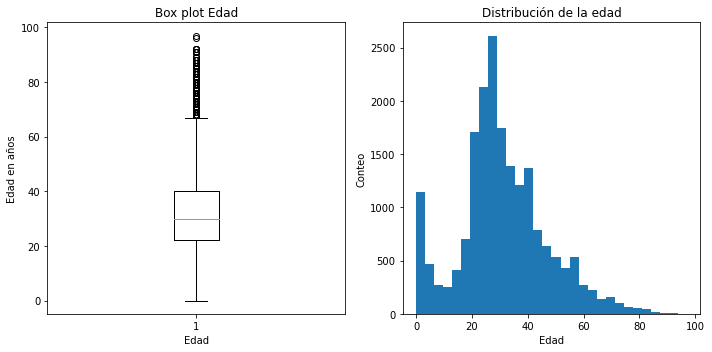

In [16]:
comp_grap(base_datos.Edad, 'Edad', 'Edad en años', 'Box plot Edad', 'Distribución de la edad')

The description of age reveals that the count of data is 19,407 observations. The mean age is approximately 31.2 years, with a standard deviation of around 15.8 years. The minimum recorded value is 0 years, indicating the presence of outliers or data collection errors. 25% of the recorded ages are below 22 years, while 50% are below 30 years. 75% of the ages fall below 40 years, indicating a distribution skewed towards younger ages. The maximum recorded age is 97 years, suggesting the presence of a smaller group of older individuals in the dataset.

In [17]:
def bar_graps(var, x_label, y_label, title, rot):
    """
    Arguments:

    -var: categorical variable to create the bar chart.
    -x_label: label for the x-axis.
    -y_label: label for the y-axis.
    -title: title of the chart.
    -rot: rotation angle of the x-axis labels (in degrees).
    Returns:

    -None: displays the bar chart.
    """
    plt.bar(var.value_counts().index.to_list(), var.value_counts().to_list() )
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)
    plt.xticks(rotation=rot)
    plt.show()

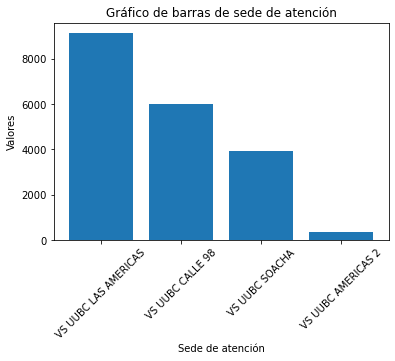

In [18]:
# Distribución de lugar de atención
bar_graps(base_datos.SedeAtencion, 'Sede de atención', 'Valores', 'Gráfico de barras de sede de atención', 45)


In [19]:
base_datos.SedeAtencion.value_counts(normalize = True)

VS UUBC LAS AMERICAS    0.470500
VS UUBC CALLE 98        0.308033
VS UUBC SOACHA          0.202659
VS UUBC AMERICAS 2      0.018808
Name: SedeAtencion, dtype: float64

These values represent percentages of attention distribution across different locations. UUBC Las Américas accounts for 47.05% of the total attention, making it the location with the highest proportion. UUBC Calle 98 follows with 30.80% of the attention, indicating a slightly lower percentage. UUBC Soacha represents 20.27% of the attention, while UUBC Americas 2 has the lowest percentage at 1.88%. These figures highlight the varying proportions of attention allocated to each respective location.

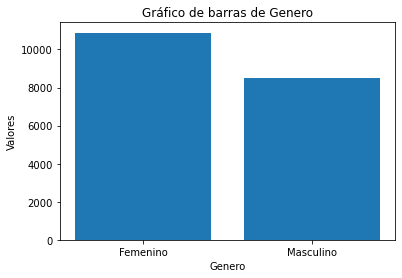

In [20]:
# Distribución de lugar de atención
bar_graps(base_datos.Genero, 'Genero', 'Valores', 'Gráfico de barras de Genero', 0)

In [21]:
base_datos.Genero.value_counts(normalize = True)

Femenino     0.560726
Masculino    0.439274
Name: Genero, dtype: float64

The percentage breakdown of the patient population by gender reveals that 56.07% are female, while 43.93% are male. This indicates that a larger proportion of the patients are female, accounting for over half of the total population, while males make up the remaining percentage.

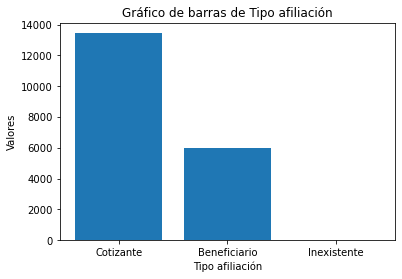

In [22]:
# Distribución de lugar de atención
bar_graps(base_datos.TipoAfiliado, 'Tipo afiliación', 'Valores', 'Gráfico de barras de Tipo afiliación', 0)

In [23]:
base_datos.TipoAfiliado.value_counts(normalize = True)

Cotizante       0.692585
Beneficiario    0.307157
Inexistente     0.000258
Name: TipoAfiliado, dtype: float64

These values pertain to the type of affiliation among individuals. The breakdown is as follows: 69.26% are classified as "Cotizante" (contributor), 30.72% are "Beneficiario" (beneficiary), and a very small proportion of 0.03% are labeled as "Inexistente" (non-existent). These percentages provide insights into the distribution of individuals based on their affiliation types within the dataset.

### Base de consultas

In [24]:
base_consulta.head(2)

,ID_TM_Afiliado_cod,IdConsulta_cod,Fecha,DIA,MES,AÑO,TAS,TAD,TAM,FC,FR,Temp,Oximetria,Anotacion TRIAGE Consulta,ClasificaTriage
0,0a2540cbb1716ce37fc2ff4bc3235cc7,9a496b44126d7e7f78cb73a5f9efff7a,24/12/2021,24,12,2021,128,70,"89,33",91,19,360.0,98,M.C: TENGO UN DOLOR ABDOMINAL EN LA PARTE INF...,2
1,cbbf900f3088367926b2807ccd0b7f3a,2bf9ceccb7de98e28c2c9aaa405b2626,7/01/2022,7,1,2022,122,78,"92,67",100,18,380.0,97,PACIENTE REFIERE DOLOR DE ESPALDA Y DOLOR...,3


In [25]:
# Nro de registros y columnas
base_consulta.shape

(20000, 15)

In [26]:
# Nro duplicados
base_consulta.duplicated().sum()

0

In [27]:
# Nro valores unicos por columna
base_consulta.nunique()

ID_TM_Afiliado_cod           19062
IdConsulta_cod               20000
Fecha                          502
DIA                             31
MES                             12
AÑO                              2
TAS                            168
TAD                            125
TAM                            332
FC                             163
FR                              73
Temp                             8
Oximetria                       50
Anotacion TRIAGE Consulta    19613
ClasificaTriage                  5
dtype: int64

In [28]:
# Valores faltantes
base_consulta.isna().sum()

ID_TM_Afiliado_cod            0
IdConsulta_cod                0
Fecha                         0
DIA                           0
MES                           0
AÑO                           0
TAS                           0
TAD                           0
TAM                           0
FC                            0
FR                            0
Temp                         46
Oximetria                     0
Anotacion TRIAGE Consulta     0
ClasificaTriage               0
dtype: int64

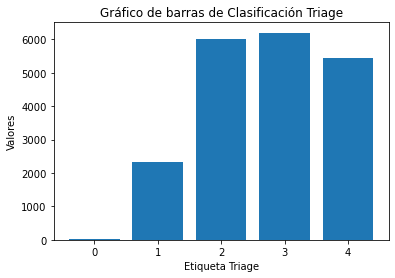

In [29]:
# Distribución de lugar de atención
bar_graps(base_consulta.ClasificaTriage , 'Etiqueta Triage', 'Valores', 'Gráfico de barras de Clasificación Triage', 0)

In [30]:
base_consulta.ClasificaTriage.value_counts(normalize = True)

3    0.3100
2    0.3010
4    0.2714
1    0.1158
0    0.0018
Name: ClasificaTriage, dtype: float64

These values represent the distribution of consultations across different Triage categories. It's important to note that there are 5 categories, with 1 being the most critical and 5 being the least critical. Here is the breakdown along with the corresponding percentages:

* Category 3: 31.00%
* Category 2: 30.10%
* Category 4: 27.14%
* Category 1: 11.58%
* Category 0: 0.18%

It is worth mentioning that **Category 1 will not be used** in the analysis as it represents less than 1% of the data. These percentages provide insights into the relative distribution of consultations across the Triage categories, with Categories 3 and 2 being the most commonly observed.

In [31]:
base_consulta['TAM'] = base_consulta['TAM'].str.replace(',', '.').astype(float)

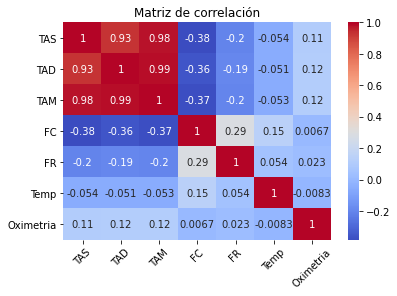

In [32]:
# Obtener la matriz de correlación
corr_matrix = base_consulta [['TAS', 'TAD', 'TAM', 'FC', 'FR', 'Temp', 'Oximetria']].corr()

# Crear el mapa de calor
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')

# Personalizar el mapa de calor
plt.title('Matriz de correlación')
plt.xticks(rotation=45)
plt.yticks(rotation=0)

# Mostrar el mapa de calor
plt.show()

### Reamrk

The correlation matrix reveals the correlations among different variables. It's important to note that the variables TAS (Systolic Blood Pressure), TAD (Diastolic Blood Pressure), and TAM (Mean Arterial Pressure) exhibit high correlation coefficients. Therefore, we will only use TAM, as it is derived from both TAD and TAS.

Based on the high correlation between TAS, TAD, and TAM, we will use TAM as the representative variable.

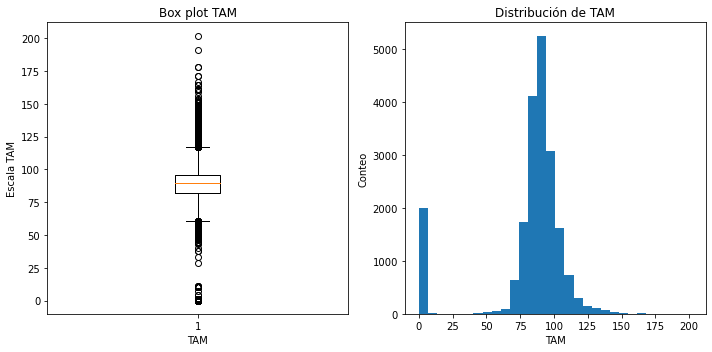

In [33]:
comp_grap(base_consulta.TAM, 'TAM', 'Escala TAM', 'Box plot TAM', 'Distribución de TAM')

In [34]:
base_consulta.TAM.describe()

count    20000.000000
mean        82.487433
std         29.482035
min          0.000000
25%         82.000000
50%         89.330000
75%         96.000000
max        202.000000
Name: TAM, dtype: float64

The descriptive statistics for TAM (Mean Arterial Pressure) are as follows: The mean value is 82.487433, with a standard deviation of 29.482035. The minimum recorded value is 0.000000, indicating the presence of potential outliers or measurement errors. The 25th percentile is 82.000000, meaning that 25% of the data falls below this value. The median (50th percentile) is 89.330000, representing the midpoint of the data distribution. The 75th percentile is 96.000000, indicating that 75% of the data falls below this value. The maximum recorded value is 202.000000, highlighting the presence of potentially extreme measurements. These statistics provide a summary of the distribution and variability of the Mean Arterial Pressure values.

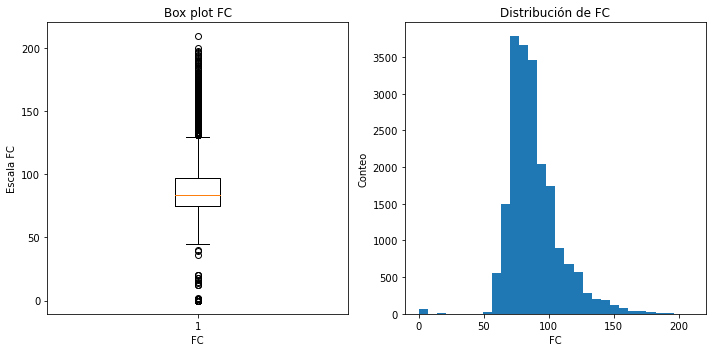

In [35]:
comp_grap(base_consulta.FC, 'FC', 'Escala FC', 'Box plot FC', 'Distribución de FC')

In [36]:
base_consulta.FC.describe()

count    20000.000000
mean        87.850500
std         19.922269
min          0.000000
25%         75.000000
50%         84.000000
75%         97.000000
max        210.000000
Name: FC, dtype: float64

The descriptive statistics for Heart Rate (FC) are as follows: The mean value is 87.850500, with a standard deviation of 19.922269. The minimum recorded value is 0.000000, indicating potential outliers or measurement errors. The 25th percentile is 75.000000, meaning that 25% of the data falls below this value. The median (50th percentile) is 84.000000, representing the midpoint of the data distribution. The 75th percentile is 97.000000, indicating that 75% of the data falls below this value. The maximum recorded value is 210.000000, suggesting the presence of potentially extreme measurements. These statistics provide a summary of the distribution and variability of Heart Rate values.

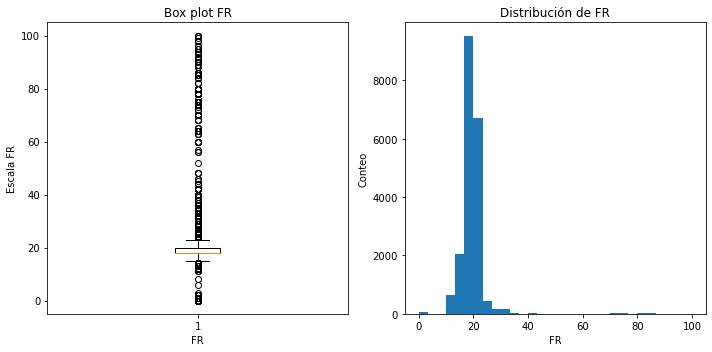

In [37]:
comp_grap(base_consulta.FR, 'FR', 'Escala FR', 'Box plot FR', 'Distribución de FR')

In [38]:
base_consulta.FR.describe()

count    20000.000000
mean        19.168950
std          5.566584
min          0.000000
25%         18.000000
50%         18.000000
75%         20.000000
max        100.000000
Name: FR, dtype: float64

The descriptive statistics for Respiratory Rate (FR) are as follows: The mean value is 19.168950, with a standard deviation of 5.566584. The minimum recorded value is 0.000000, suggesting potential outliers or measurement errors. The 25th percentile is 18.000000, indicating that 25% of the data falls below this value. Both the median (50th percentile) and the 75th percentile are 18.000000, suggesting that the data is concentrated around this value. The maximum recorded value is 100.000000, indicating the presence of potentially extreme measurements. These statistics provide a summary of the distribution and variability of Respiratory Rate values.

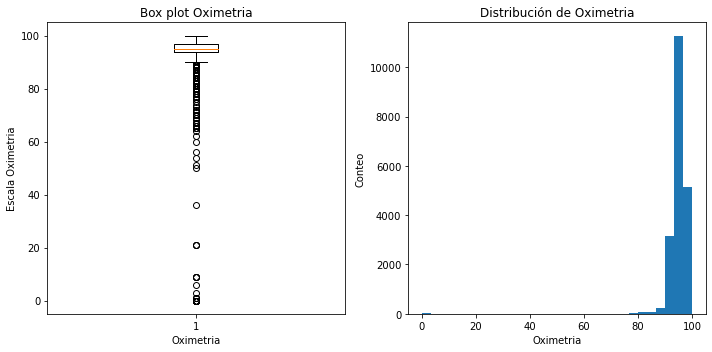

In [39]:
comp_grap(base_consulta.Oximetria, 'Oximetria', 'Escala Oximetria', 'Box plot Oximetria', 'Distribución de Oximetria')

In [40]:
base_consulta.Oximetria.describe()

count    20000.000000
mean        94.927900
std          4.693475
min          0.000000
25%         94.000000
50%         95.000000
75%         97.000000
max        100.000000
Name: Oximetria, dtype: float64

### Remark 

Finally, it is worth mentioning that there are many outliers observed in the vital signs variables. However, it is important to note that these data points are from an emergency room setting, where the presence of outliers is expected. Therefore, **no outlier data will be removed from the dataset**, as they are considered valuable and representative of the real-world scenarios encountered in an emergency healthcare environment.

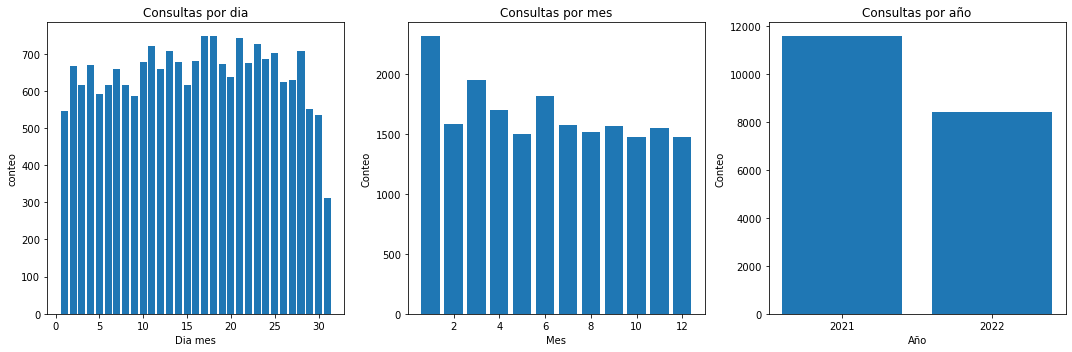

In [41]:
# Box plot de la variable edad
fig, (ax1,ax2, ax3) = plt.subplots(1, 3,figsize=(15,5))
#plt.figure(figsize=(8,12))
ax1.bar(base_consulta.groupby('DIA')['DIA'].count().sort_values(ascending = False).index.to_list(), base_consulta.groupby('DIA')['DIA'].count().sort_values(ascending = False).values )
ax1.set_xlabel('Dia mes')
ax1.set_ylabel('conteo')
ax1.set_title('Consultas por dia')

ax2.bar(base_consulta.groupby('MES')['MES'].count().sort_values(ascending = False).index.to_list(), base_consulta.groupby('MES')['MES'].count().sort_values(ascending = False).values )
ax2.set_xlabel('Mes')
ax2.set_ylabel('Conteo')
ax2.set_title('Consultas por mes')

ax3.bar(['2021','2022'], base_consulta.groupby('AÑO')['AÑO'].count().sort_values(ascending = False).values )
ax3.set_xlabel('Año')
ax3.set_ylabel('Conteo')
ax3.set_title('Consultas por año')

plt.tight_layout()

plt.show()

In [42]:
base_consulta.groupby('AÑO')['AÑO'].count()/20000

AÑO
2021    0.57945
2022    0.42055
Name: AÑO, dtype: float64

In [43]:
base_consulta.groupby('DIA')['DIA'].count().sort_values(ascending = False)/20000

DIA
18    0.03735
17    0.03735
21    0.03710
23    0.03635
11    0.03610
28    0.03540
13    0.03540
25    0.03505
24    0.03430
16    0.03400
14    0.03395
10    0.03385
22    0.03370
19    0.03365
4     0.03350
2     0.03335
12    0.03290
7     0.03290
20    0.03190
27    0.03140
26    0.03125
6     0.03085
15    0.03085
8     0.03080
3     0.03075
5     0.02955
9     0.02925
29    0.02755
1     0.02735
30    0.02675
31    0.01555
Name: DIA, dtype: float64

In [44]:
base_consulta.groupby('MES')['MES'].count().sort_values(ascending = False)/20000

MES
1     0.11565
3     0.09740
6     0.09065
4     0.08490
2     0.07900
7     0.07875
9     0.07820
11    0.07725
8     0.07595
5     0.07505
10    0.07365
12    0.07355
Name: MES, dtype: float64

On the other hand, more than 51% of the attentions were given in the first half of the year. In addition, the days with the least number of queries are generally in the last days of the month, as shown below.

## Data Preprocessing
Data preprocessing stages were performed to ensure the quality and consistency of the data. This included handling outliers, normalizing numerical data, and encoding categorical variables. Text analysis was also conducted to transform the text recorded by healthcare professionals into numerical features that could be used by the model.


In [45]:
base = base_datos.merge(base_consulta, on = ['ID_TM_Afiliado_cod'], how = 'left').drop_duplicates(['ID_TM_Afiliado_cod', 'IdConsulta_cod'])

In [46]:
base.nunique()

ID_TM_Afiliado_cod           19062
Edad                            94
Genero                           2
SedeAtencion                     4
TipoAtencion                     1
TipoAfiliado                     3
IdConsulta_cod               20000
Fecha                          502
DIA                             31
MES                             12
AÑO                              2
TAS                            168
TAD                            125
TAM                            332
FC                             163
FR                              73
Temp                             8
Oximetria                       50
Anotacion TRIAGE Consulta    19613
ClasificaTriage                  5
dtype: int64

In [47]:
base.head(2)

,ID_TM_Afiliado_cod,Edad,Genero,SedeAtencion,TipoAtencion,TipoAfiliado,IdConsulta_cod,Fecha,DIA,MES,AÑO,TAS,TAD,TAM,FC,FR,Temp,Oximetria,Anotacion TRIAGE Consulta,ClasificaTriage
0,0a2540cbb1716ce37fc2ff4bc3235cc7,27,Femenino,VS UUBC LAS AMERICAS,Triage,Cotizante,9a496b44126d7e7f78cb73a5f9efff7a,24/12/2021,24,12,2021,128,70,89.33,91,19,360.0,98,M.C: TENGO UN DOLOR ABDOMINAL EN LA PARTE INF...,2
1,cbbf900f3088367926b2807ccd0b7f3a,22,Femenino,VS UUBC LAS AMERICAS,Triage,Cotizante,2bf9ceccb7de98e28c2c9aaa405b2626,7/01/2022,7,1,2022,122,78,92.67,100,18,380.0,97,PACIENTE REFIERE DOLOR DE ESPALDA Y DOLOR...,3


In [48]:
base['ClasificaTriage'].value_counts(normalize = True )

3    0.3100
2    0.3010
4    0.2714
1    0.1158
0    0.0018
Name: ClasificaTriage, dtype: float64

In [49]:
# Filtro clase diferente a 0
base = base.query('ClasificaTriage > 0')

In [50]:
base.isna().sum()

ID_TM_Afiliado_cod            0
Edad                          0
Genero                        0
SedeAtencion                  0
TipoAtencion                  0
TipoAfiliado                  0
IdConsulta_cod                0
Fecha                         0
DIA                           0
MES                           0
AÑO                           0
TAS                           0
TAD                           0
TAM                           0
FC                            0
FR                            0
Temp                         46
Oximetria                     0
Anotacion TRIAGE Consulta     0
ClasificaTriage               0
dtype: int64

In [51]:
base['Temp']= base['Temp'].fillna(base['Temp'].mean())
#base = base.dropna()

In [52]:
base['ClasificaTriage'].value_counts( )

3    6200
2    6020
4    5428
1    2316
Name: ClasificaTriage, dtype: int64

## Cleaning

In [53]:
def limpieza(text):
  """
    Performs text cleanup by removing non-alphanumeric characters and converting them to lowercase.

    Arguments:
    - text: text to clean.

    Returns:
    - clean_text: clean text without non-alphanumeric characters and in lower case.
    """
  text_limpio = re.sub('[\W]+', ' ', text.lower())
  return text_limpio

In [54]:
base['final'] = base['Anotacion TRIAGE Consulta'].apply(limpieza).apply(str)

# Feature Selection
## Number of words

Keywords were determined using the tf-idf model, comparing the variance explained by different subsets of words.

In [55]:
my_stopwords = stopwords.words('spanish')

In [56]:
tfidf = TfidfVectorizer(stop_words= my_stopwords)

In [57]:
docs = base['final'].values

In [58]:
X = tfidf.fit_transform(docs)

In [59]:
X.shape

(19964, 22635)

In [60]:
variance = []
for i in [100, 200, 300, 400,500, 600, 700, 800, 900,1000]:
    tfidf_temp = TfidfVectorizer(stop_words= my_stopwords, max_features=i)
    X_temp = tfidf_temp.fit_transform(docs)
    variance.append(X_temp.sum()/X.sum())
    print(i, X_temp.sum()/X.sum())

100 0.7356643293146384
200 0.8026893989778731
300 0.834870290194574
400 0.8551939268139307
500 0.8707019153372053
600 0.8826795092497388
700 0.8924636433759567
800 0.9002040236517158
900 0.9070336445714342
1000 0.9126285738833184


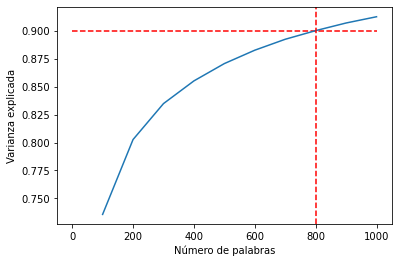

In [61]:
plt.xlabel('Número de palabras')
plt.ylabel('Varianza explicada')
plt.plot([100, 200, 300, 400,500, 600, 700, 800, 900,1000], variance)
plt.axvline(x=800, linestyle='--', color='r') # Línea vertical en 500
plt.hlines(y=0.90, xmin=0, xmax=1000, linestyle='--', color='r') # Línea horizontal en 0.95
plt.show()

Note that, from a set of 22,635 different words in the text corpus, the 800 most significant words are selected. As can be seen in the graph, with this amount of words, approximately 90% of the information is captured in the text present in the database.

## Preparation of text data

In [62]:
# Base solo texto
X_texto = base['final'].values
y_texto= base['ClasificaTriage'].values

In [63]:
my_stopwords = stopwords.words('spanish')

In [64]:
vectorizer_texto = TfidfVectorizer(stop_words= my_stopwords)
tfidf_matrix = vectorizer_texto.fit_transform(X_texto)

In [65]:
def get_most_important_words_index(tfidf_matrix, vectorizer, n=10):
    """
    Devuelve los índices de las n palabras más importantes en la matriz TF-IDF
    """
    # Obtiene el vector de características que representa el vocabulario
    feature_names = vectorizer.vocabulary_.keys()
    feature_names = list(feature_names)

    # Obtiene la puntuación media de TF-IDF para cada palabra en la matriz TF-IDF
    mean_tfidf_scores = tfidf_matrix.mean(axis=0)

    # Crea una lista de tuplas (índice de la palabra, puntuación TF-IDF media)
    word_scores = [(col, mean_tfidf_scores[0, col]) for col in range(len(list(set(tfidf_matrix.nonzero()[1]))))]

    # Ordena la lista de palabras por la puntuación TF-IDF media en orden descendente
    sorted_word_scores = sorted(word_scores, key=lambda x: x[1], reverse=True)

    # Obtiene los índices de las n palabras más importantes
    top_word_indices = [x[0] for x in sorted_word_scores[:n]]

    return top_word_indices

In [66]:
important_words_index = get_most_important_words_index(tfidf_matrix, vectorizer_texto, n=800)

In [67]:
# Selecciona las columnas correspondientes a las palabras más importantes
X_texto_reduced = tfidf_matrix[:, important_words_index]
X_texto_reduced.shape

(19964, 800)

In [68]:
# Obtenemos los nombres de las palabras
palabras = vectorizer_texto.vocabulary_.keys()

# Calculamos el puntaje TF-IDF promedio para cada palabra
puntajes = tfidf_matrix.mean(axis=0).tolist()[0]

# Creamos una lista de tuplas (palabra, puntaje) y ordenamos por puntaje
palabras_puntajes = list(zip(palabras, puntajes))
palabras_puntajes.sort(key=lambda x: x[1], reverse=True)

print("Top 10 most important words:")
for palabra, puntaje in palabras_puntajes[:10]:
    print("- {} ({:.4f})".format(palabra, puntaje))


Top 10 most important words:
- edeama (0.0734)
- seme (0.0605)
- madrugdad (0.0378)
- aferbol (0.0363)
- slqiuidas (0.0363)
- bilaterla (0.0338)
- residente (0.0294)
- 2021tengo (0.0287)
- cumpla (0.0271)
- tramiento (0.0265)


## Important numerical and categorical variables

This selection is done by first identifying which variables have the strongest relationship with the target variable, using the python selectKbest module.

In [69]:
base_numerica = base[['Edad', 'Genero',  'ClasificaTriage', 'SedeAtencion' , 'TipoAfiliado',  'TAM','FC', 'FR', 'Temp', 'Oximetria']]

In [70]:
X_num = pd.get_dummies(base_numerica, drop_first = True).drop('ClasificaTriage', axis = 1)
y_num= base_numerica['ClasificaTriage'].values

In [71]:
#k_best = SelectKBest(f_classif, k=6)
#X_new = k_best.fit_transform(X_num, y_num)
#X_num = X_num.iloc[:,list(k_best.get_support())]

In [72]:
scaler = StandardScaler()
scaler.fit(X_num)
X_scaled = scaler.transform(X_num)

In [73]:
X_num

,Edad,TAM,FC,FR,Temp,Oximetria,Genero_Masculino,SedeAtencion_VS UUBC CALLE 98,SedeAtencion_VS UUBC LAS AMERICAS,SedeAtencion_VS UUBC SOACHA,TipoAfiliado_Cotizante,TipoAfiliado_Inexistente
0,27,89.33,91,19,360.0,98,0,0,1,0,1,0
1,22,92.67,100,18,380.0,97,0,0,1,0,1,0
2,40,88.00,114,21,360.0,96,0,1,0,0,1,0
3,19,80.00,76,18,360.0,95,0,0,1,0,0,0
4,26,105.67,111,16,360.0,94,1,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
20737,26,102.33,92,21,360.0,95,0,0,1,0,1,0
20738,74,114.00,94,16,360.0,95,1,0,0,1,1,0
20739,1,0.00,148,26,360.0,92,1,1,0,0,0,0
20740,42,46.33,96,18,360.0,97,1,1,0,0,1,0


In [74]:
def importancia_variables_modelo(df, y, modelo):

    scaler = StandardScaler()
    scaler.fit(df)
    X_scaled = scaler.transform(df)

    X_num_train, X_num_test, y_num_train, y_num_test = train_test_split(X_scaled, y_num, test_size=0.2, random_state=42)

    var = []

    for i in range(1,df.shape[1]):
      selector = SelectKBest(f_classif, k=i)
      X_train_selected = selector.fit_transform(X_num_train, y_num_train)

      model = modelo
      modelo.fit(X_train_selected, y_num_train)

      selected_features_score = modelo.score(X_train_selected, y_num_train)

      model_all_features = modelo
      model_all_features.fit(X_num_train, y_num_train)

      all_features_score = model_all_features.score(X_num_train, y_num_train)

      var.append(selected_features_score/all_features_score)

      #print(f"La variabilidad explicada por las {i:.2f} características seleccionadas es: {(selected_features_score/all_features_score):.2f} %")

    return var

In [75]:
var_random_forest = importancia_variables_modelo(X_num, y_num, RandomForestClassifier())

In [76]:
var_logistic_reg = importancia_variables_modelo(X_num, y_num, LogisticRegression())

In [77]:
var_red = importancia_variables_modelo(X_num, y_num, MLPClassifier())

### Remark 

On the other hand, in order to select the number of variables to select, the analysis of the performance of base models such as logistic regression and random forest trained with all the variables is performed compared to performance if we train it only with a subset of the variables as observed in the graph. In conclusion, we see that with 6 variables we achieve 90% performance in the models compared to training with all the variables.

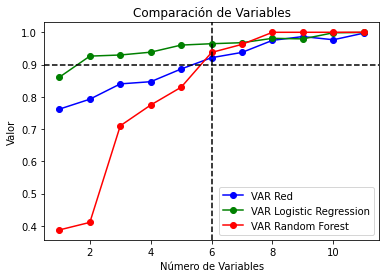

In [78]:
x = range(1, X_num.shape[1])
plt.plot(x, var_red, 'bo-', label='VAR Red')
plt.plot(x, var_logistic_reg, 'go-', label='VAR Logistic Regression')
plt.plot(x, var_random_forest, 'ro-', label='VAR Random Forest')



# Agregar leyenda y títulos
plt.legend()

# Línea punteada en x = 6
plt.axvline(x=6, color='k', linestyle='--', label='x = 6')

# Línea punteada en y = 0.9
plt.axhline(y=0.9, color='k', linestyle='--', label='y = 0.9')

plt.title('Comparación de Variables')
plt.xlabel('Número de Variables')
plt.ylabel('Valor')

# Mostrar la gráfica
plt.show()

## Preparation of numerical data

In [79]:
X_num = pd.get_dummies(base_numerica, drop_first = True).drop('ClasificaTriage', axis = 1)

k_best = SelectKBest(f_classif, k=6)
X_new = k_best.fit_transform(X_num, y_num)
X_num = X_num.iloc[:,list(k_best.get_support())]

In [80]:
X_num.shape

(19964, 6)

In [81]:
#X_num = X_num[:,k_best.get_support()]

In [82]:
mask = k_best.get_support()

In [83]:
base_num = pd.get_dummies(base_numerica, drop_first = True).drop('ClasificaTriage', axis = 1)

In [84]:
fvalues, pvalues = f_classif(base_num.iloc[:, mask], y_num)

### Remark 

For the selection of the most important numerical variables, the relationship of each variable with the objective variable is measured through correlation, resulting in the 6 most important variables in descending order:

In [85]:
df = pd.DataFrame({'Característica': base_num.columns[mask], 'F': fvalues, 'p-valor': pvalues})
df.sort_values('F')

,Característica,F,p-valor
2,FR,83.485833,1.128689e-53
3,Genero_Masculino,112.504864,3.062917e-72
4,SedeAtencion_VS UUBC LAS AMERICAS,137.392952,4.113533e-88
0,TAM,295.245890,1.501386e-187
5,TipoAfiliado_Cotizante,493.382263,2.636561e-309
1,FC,584.480457,0.000000e+00


## Development modeling phase

In this notebook a complete analysis of the training of three algorithms to solve a multiclass problem is presented.

The first phase is the training of the algorithms using only the numerical data, using the grid search methodology to search for the best hyperparameters and their corresponding evaluation. The metrics obtained for each model are presented.

The second phase repeats the previous process, but including the text data. It shows how the models improve by incorporating this additional information and the results are compared with the previous phase.

In the third phase, a joint training is carried out with the numerical and text data. The grid search methodology is used again and the resulting models are evaluated. In addition, the most important features are extracted and the relevant results of the selected model are presented.

In summary, this part of the project provides a complete vision of the process of training several algorithms to solve a multiclass problem, using different methodologies and data. The metrics and results obtained in each phase are presented, which allows comparing the different models and determining which is the most appropriate for the problem.





# Numerical modeling
## Definition of the metric to optimize

In [86]:
def evaluate_model(model,x_test, y_test):
    y_pred = model.predict(x_test)
    y_pred = pd.DataFrame(y_pred)

    clsReport = classification_report( y_test,y_pred )
    return clsReport

In [87]:
X_num_train, X_num_test, y_num_train, y_num_test = train_test_split(X_scaled, y_num, test_size=0.2, random_state=42)

In [88]:
scorer = make_scorer(f1_score, average='macro')

## Logistic Regression

In [89]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Transformador: StandardScaler
    ('classifier_lr', LogisticRegression())
])

parameters = {
    'scaler__with_mean': [True, False],
    'classifier_lr__C': [0.1, 1.0]
}

cv_reg = GridSearchCV(pipeline, param_grid=parameters, cv= 3, n_jobs = -1, scoring = scorer )

cv_reg.fit(X_num_train, y_num_train)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('classifier_lr',
                                        LogisticRegression())]),
             n_jobs=-1,
             param_grid={'classifier_lr__C': [0.1, 1.0],
                         'scaler__with_mean': [True, False]},
             scoring=make_scorer(f1_score, average=macro))

In [90]:
print(evaluate_model(cv_reg,X_num_test, y_num_test))

              precision    recall  f1-score   support

           1       0.61      0.17      0.26       462
           2       0.47      0.46      0.46      1249
           3       0.36      0.46      0.40      1256
           4       0.39      0.40      0.39      1026

    accuracy                           0.41      3993
   macro avg       0.46      0.37      0.38      3993
weighted avg       0.43      0.41      0.40      3993



## Random Forest

In [91]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Transformador: StandardScaler
    ('classifier_rf', RandomForestClassifier())
])

parameters = {
    'scaler__with_mean': [True, False],
    'classifier_rf__n_estimators': [50,100]
}

cv_rf = GridSearchCV(pipeline, param_grid=parameters, cv= 3, n_jobs = -1, scoring = scorer )

cv_rf.fit(X_num_train, y_num_train)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('classifier_rf',
                                        RandomForestClassifier())]),
             n_jobs=-1,
             param_grid={'classifier_rf__n_estimators': [50, 100],
                         'scaler__with_mean': [True, False]},
             scoring=make_scorer(f1_score, average=macro))

In [92]:
print(evaluate_model(cv_rf,X_num_test, y_num_test))

              precision    recall  f1-score   support

           1       0.56      0.31      0.40       462
           2       0.49      0.46      0.47      1249
           3       0.40      0.47      0.43      1256
           4       0.41      0.44      0.42      1026

    accuracy                           0.44      3993
   macro avg       0.47      0.42      0.43      3993
weighted avg       0.45      0.44      0.44      3993



## Neuronal Network

In [93]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Transformador: StandardScaler
    ('classifier_rn', MLPClassifier())
])

parameters = {
    'scaler__with_mean': [True, False],
    'classifier_rn__hidden_layer_sizes': [(50,), (100,)]
}

cv_rn = GridSearchCV(pipeline, param_grid=parameters, cv= 3, n_jobs = -1, scoring = scorer )

cv_rn.fit(X_num_train, y_num_train)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('classifier_rn', MLPClassifier())]),
             n_jobs=-1,
             param_grid={'classifier_rn__hidden_layer_sizes': [(50,), (100,)],
                         'scaler__with_mean': [True, False]},
             scoring=make_scorer(f1_score, average=macro))

In [94]:
print(evaluate_model(cv_rn,X_num_test, y_num_test))

              precision    recall  f1-score   support

           1       0.59      0.30      0.40       462
           2       0.52      0.48      0.50      1249
           3       0.41      0.36      0.38      1256
           4       0.39      0.57      0.46      1026

    accuracy                           0.44      3993
   macro avg       0.48      0.43      0.44      3993
weighted avg       0.46      0.44      0.44      3993



### Remark
In the numerical phase, the best model was a neural network. Although this model was able to adequately classify some categories, it is observed that the general metrics are moderate, indicating the need for improvements.



# Text shaping
## Logistic regression

In [95]:
def tokenize(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    tokens = text.split()
    return tokens

In [96]:
X_texto = base['Anotacion TRIAGE Consulta'].values
y_texto = base['ClasificaTriage'].values

In [97]:
X_text_train, X_text_test, y_text_train, y_text_test = train_test_split(X_texto, y_texto, test_size=0.2, random_state=42)

In [98]:
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(tokenizer=tokenize, stop_words = my_stopwords, max_features= 800)),
    ('classifier', LogisticRegression())
])

parameters = {
    'tfidf__use_idf': (True, False),
    'classifier__C': [0.1, 1.0]
}

cv_reg_text = GridSearchCV(pipeline, param_grid=parameters, cv= 3, n_jobs = -1, scoring = scorer )

cv_reg_text.fit(X_text_train, y_text_train)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('tfidf',
                                        TfidfVectorizer(max_features=800,
                                                        stop_words=['de', 'la',
                                                                    'que', 'el',
                                                                    'en', 'y',
                                                                    'a', 'los',
                                                                    'del', 'se',
                                                                    'las',
                                                                    'por', 'un',
                                                                    'para',
                                                                    'con', 'no',
                                                                    'una', 'su',
                                                               

In [99]:
print(evaluate_model(cv_reg_text,X_text_test, y_text_test))

              precision    recall  f1-score   support

           1       0.72      0.48      0.57       462
           2       0.63      0.66      0.64      1249
           3       0.56      0.63      0.60      1256
           4       0.60      0.57      0.58      1026

    accuracy                           0.61      3993
   macro avg       0.63      0.58      0.60      3993
weighted avg       0.61      0.61      0.61      3993



## Random Forest

In [100]:
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(tokenizer=tokenize, stop_words = my_stopwords, max_features= 800)),
    ('classifier', RandomForestClassifier())
])

parameters = {
    'tfidf__use_idf': (True, False),
    'classifier__n_estimators': [50, 100]
}

cv_rf_text = GridSearchCV(pipeline, param_grid=parameters, cv= 3, n_jobs = -1, scoring = scorer )

cv_rf_text.fit(X_text_train, y_text_train)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('tfidf',
                                        TfidfVectorizer(max_features=800,
                                                        stop_words=['de', 'la',
                                                                    'que', 'el',
                                                                    'en', 'y',
                                                                    'a', 'los',
                                                                    'del', 'se',
                                                                    'las',
                                                                    'por', 'un',
                                                                    'para',
                                                                    'con', 'no',
                                                                    'una', 'su',
                                                               

In [101]:
print(evaluate_model(cv_rf_text,X_text_test, y_text_test))

              precision    recall  f1-score   support

           1       0.77      0.45      0.56       462
           2       0.60      0.64      0.62      1249
           3       0.54      0.62      0.57      1256
           4       0.59      0.54      0.56      1026

    accuracy                           0.59      3993
   macro avg       0.62      0.56      0.58      3993
weighted avg       0.60      0.59      0.59      3993



## Neuronal network

In [102]:
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(tokenizer=tokenize, stop_words = my_stopwords, max_features= 800)),
    ('classifier', MLPClassifier())
])

parameters = {
    'tfidf__use_idf': (True, False),
    'classifier__hidden_layer_sizes': [(50,), (100,)]
}

cv_rn_text = GridSearchCV(pipeline, param_grid=parameters, cv= 3, n_jobs = -1, scoring = scorer )

cv_rn_text.fit(X_text_train, y_text_train)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('tfidf',
                                        TfidfVectorizer(max_features=800,
                                                        stop_words=['de', 'la',
                                                                    'que', 'el',
                                                                    'en', 'y',
                                                                    'a', 'los',
                                                                    'del', 'se',
                                                                    'las',
                                                                    'por', 'un',
                                                                    'para',
                                                                    'con', 'no',
                                                                    'una', 'su',
                                                               

In [103]:
print(evaluate_model(cv_rn_text,X_text_test, y_text_test))

              precision    recall  f1-score   support

           1       0.55      0.52      0.53       462
           2       0.60      0.59      0.60      1249
           3       0.54      0.55      0.55      1256
           4       0.57      0.57      0.57      1026

    accuracy                           0.56      3993
   macro avg       0.56      0.56      0.56      3993
weighted avg       0.57      0.56      0.57      3993



### Remark 

In the text phase, logistic regression stood out as the best model, showing better performance compared to the numerical phase.
These metrics show a significant improvement in classification ability, especially in terms of accuracy and f1-score.

# Mixto

## Data preparation

An additional step before the training phase with mixed data is to prepare the data, since since structured and text data are mixed, we must correctly define the pipelines, it is important to take into account the type of structure that the data has for which it is used. a transformer that distinguishes the columns.

In [104]:
def split_dataframe(df1):
    df1 = pd.get_dummies(df1, columns = ['Genero', 'SedeAtencion', 'TipoAfiliado'],  drop_first = True)
    df1 = df1[['TAM', 'FC', 'FR', 'Genero_Masculino', 'SedeAtencion_VS UUBC LAS AMERICAS', 'TipoAfiliado_Cotizante', 'Anotacion TRIAGE Consulta', 'ClasificaTriage']]
    #X_texto = df1['Anotacion TRIAGE Consulta'].values
    return df1

In [105]:
split_dataframe(base)

,TAM,FC,FR,Genero_Masculino,SedeAtencion_VS UUBC LAS AMERICAS,TipoAfiliado_Cotizante,Anotacion TRIAGE Consulta,ClasificaTriage
0,89.33,91,19,0,1,1,M.C: TENGO UN DOLOR ABDOMINAL EN LA PARTE INF...,2
1,92.67,100,18,0,1,1,PACIENTE REFIERE DOLOR DE ESPALDA Y DOLOR...,3
2,88.00,114,21,0,0,1,ME OPERARON INGRESA PACIENTE DE 40 AÑOS CONCI...,2
3,80.00,76,18,0,1,0,DIRECCIONADA DE LA CONSULTA POR LEUCOCITOSIS ...,2
4,105.67,111,16,1,1,1,LA SEMANA PASADA EN EL TRABAJO CARGUE UNOS EQU...,4
...,...,...,...,...,...,...,...,...
20737,102.33,92,21,0,1,1,TENGO MUCHO DOLOR DE CABEZA,3
20738,114.00,94,16,1,0,1,"ANTECEDENTES (EPOC,oxigeno requirente A 2 LITR...",2
20739,0.00,148,26,1,0,0,TIENE TOS MADRE INDICA CUADRO CLINICO DE 2 D...,2
20740,46.33,96,18,1,0,1,HACE 15 DIAS ME GOLPEE EL CODO Y TENGO DOLOR ...,2


In [106]:
# Desde aqui
X = split_dataframe(base)[['TAM', 'FC', 'FR', 'Genero_Masculino', 'SedeAtencion_VS UUBC LAS AMERICAS', 'TipoAfiliado_Cotizante', 'Anotacion TRIAGE Consulta']]
y = split_dataframe(base)['ClasificaTriage']
X_mixto_train, X_mixto_test, y_mixto_train, y_mixto_test = train_test_split(X,y, test_size=0.2, random_state=42)

In [107]:
# Crear el ColumnTransformer para encadenar los transformadores
preprocessor = ColumnTransformer(
    transformers=[
        ('numeric', StandardScaler(), ['TAM', 'FC', 'FR', 'Genero_Masculino', 'SedeAtencion_VS UUBC LAS AMERICAS', 'TipoAfiliado_Cotizante']),
        ('text', TfidfVectorizer(tokenizer=tokenize, stop_words = my_stopwords, max_features= 800), 'Anotacion TRIAGE Consulta')
    ])

### Lienar regression

In [108]:
pipeline = Pipeline([
    ('preprocess', preprocessor),
    ('model', LogisticRegression())
])

param_grid = {
    'preprocess__text__ngram_range': [(1, 1), (1, 2)],  # Ejemplo de parámetro para TfidfVectorizer
    'model__C': [0.1, 1, 10]  # Ejemplo de parámetro para LogisticRegression
}

# Crear el objeto GridSearchCV
grid_search_lr = GridSearchCV(pipeline, param_grid, cv=3, scoring=scorer)

# Ajustar el GridSearchCV utilizando los datos de entrenamiento y las etiquetas
grid_search_lr.fit(X_mixto_train, y_mixto_train)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocess',
                                        ColumnTransformer(transformers=[('numeric',
                                                                         StandardScaler(),
                                                                         ['TAM',
                                                                          'FC',
                                                                          'FR',
                                                                          'Genero_Masculino',
                                                                          'SedeAtencion_VS '
                                                                          'UUBC '
                                                                          'LAS '
                                                                          'AMERICAS',
                                                                          '

In [109]:
print(evaluate_model(grid_search_lr,X_mixto_test, y_mixto_test))

              precision    recall  f1-score   support

           1       0.72      0.53      0.61       462
           2       0.65      0.68      0.66      1249
           3       0.58      0.64      0.61      1256
           4       0.61      0.58      0.60      1026

    accuracy                           0.62      3993
   macro avg       0.64      0.61      0.62      3993
weighted avg       0.63      0.62      0.62      3993



### Random Forest

In [110]:
pipeline = Pipeline([
    ('preprocess', preprocessor),
    ('model', RandomForestClassifier())
])

param_grid = {
    'preprocess__text__ngram_range': [(1, 1), (1, 2)],  # Ejemplo de parámetro para TfidfVectorizer
    'model__n_estimators': [50, 100]  # Ejemplo de parámetro para LogisticRegression
}

# Crear el objeto GridSearchCV
grid_search_rf = GridSearchCV(pipeline, param_grid, cv=3, scoring=scorer)

# Ajustar el GridSearchCV utilizando los datos de entrenamiento y las etiquetas
grid_search_rf.fit(X_mixto_train, y_mixto_train)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocess',
                                        ColumnTransformer(transformers=[('numeric',
                                                                         StandardScaler(),
                                                                         ['TAM',
                                                                          'FC',
                                                                          'FR',
                                                                          'Genero_Masculino',
                                                                          'SedeAtencion_VS '
                                                                          'UUBC '
                                                                          'LAS '
                                                                          'AMERICAS',
                                                                          '

In [111]:
print(evaluate_model(grid_search_rf,X_mixto_test, y_mixto_test))

              precision    recall  f1-score   support

           1       0.81      0.47      0.60       462
           2       0.64      0.70      0.67      1249
           3       0.57      0.66      0.61      1256
           4       0.62      0.54      0.58      1026

    accuracy                           0.62      3993
   macro avg       0.66      0.60      0.61      3993
weighted avg       0.63      0.62      0.62      3993



### Neuronal network

In [112]:
pipeline = Pipeline([
    ('preprocess', preprocessor),
    ('model', MLPClassifier())
])

param_grid = {
    'preprocess__text__ngram_range': [(1, 1), (1, 2)],  # Ejemplo de parámetro para TfidfVectorizer
    'model__hidden_layer_sizes': [(50,), (100,)]  # Ejemplo de parámetro para LogisticRegression
}

# Crear el objeto GridSearchCV
grid_search_rn = GridSearchCV(pipeline, param_grid, cv=3, scoring=scorer)

# Ajustar el GridSearchCV utilizando los datos de entrenamiento y las etiquetas
grid_search_rn.fit(X_mixto_train, y_mixto_train)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocess',
                                        ColumnTransformer(transformers=[('numeric',
                                                                         StandardScaler(),
                                                                         ['TAM',
                                                                          'FC',
                                                                          'FR',
                                                                          'Genero_Masculino',
                                                                          'SedeAtencion_VS '
                                                                          'UUBC '
                                                                          'LAS '
                                                                          'AMERICAS',
                                                                          '

In [113]:
print(evaluate_model(grid_search_rn,X_mixto_test, y_mixto_test))

              precision    recall  f1-score   support

           1       0.54      0.55      0.54       462
           2       0.63      0.61      0.62      1249
           3       0.55      0.58      0.57      1256
           4       0.59      0.57      0.58      1026

    accuracy                           0.58      3993
   macro avg       0.58      0.58      0.58      3993
weighted avg       0.58      0.58      0.58      3993



### Remark 

In the mixed phase, the Random Forest model showed outstanding performance in triage classification.

Those metrics reflect a significant improvement compared to previous phases, demonstrating the effectiveness of the model in accurately classifying triage categories. Specifically, the model achieved high accuracy in category 1, with an f1-score of 0.61, and also performed well in categories 2, 3, and 4, with f1-scores of 0.67, 0.61, and 0.59, respectively.

## Save the final model

Taking into account that we have already identified the model with the best performance under the parameters defined at the beginning. The code is ready to save the model in pkl format and be used with an interface for its deployment. However, that is not part of the proposed scope of this project.

In [114]:
def save_model(model, model_filepath):
    with open(model_filepath, 'wb') as file:
        pickle.dump(model, file)

In [115]:
save_model(grid_search_rf, 'final_model.pkl' )

## Demo:

A set of 10 records is taken at random and the model is tested to work correctly.

In [117]:
X_mixto_test.sample(10, random_state = 123)

,TAM,FC,FR,Genero_Masculino,SedeAtencion_VS UUBC LAS AMERICAS,TipoAfiliado_Cotizante,Anotacion TRIAGE Consulta
16383,114.67,98,20,1,1,1,"HACE UN MES TUVE UN ACCIDENTE LABORAL, ME HICI..."
9655,91.00,90,19,0,1,0,ESTOY VOMITO SOLTURA MUCHA TOS SECA
17048,77.33,103,16,0,0,0,AGRESIÓN EN 2 DEDO MANO IZQUIERDA AYER 6 PM ...
11826,92.33,115,19,1,1,1,"DESDE ANCOHE TENGO VOMITO,DIARREA Y ESTOY DEBIL"
5552,86.67,78,18,0,0,1,REFIERE DE 3 DIAS DE EVOLUCION DE DISURIA...
8428,85.67,96,21,1,0,1,TENGO DOS DOLORES INGRESA PACIENTE DE 24 AÑO...
4948,97.00,78,18,0,0,1,FUR: 07/09/2021 TENGO VOMITO CON CUADRO C...
6422,88.67,87,19,1,0,1,EYER ME VACUNARON Y HOY TENGO FIEBRE ESCALOFRI...
13465,86.67,79,16,0,0,1,VENGO A CONTROL ECOGRAFICO PACIENTE GESTANTE Q...
4454,99.00,82,19,1,1,1,SE RECLASIFICA PACIENTE PRIORIDAD 2


In [118]:
grid_search_rf.predict(X_mixto_test.sample(10, random_state = 123))

array([4, 3, 2, 3, 2, 3, 3, 4, 1, 1], dtype=int64)

## Conclusions
In summary, this project addressed the challenge of triage classification in health services. Using various models and techniques, we developed a comprehensive solution that supports healthcare professionals to accurately triage patients.

Regarding improvements: It is suggested to continue the investigation to improve the experiment. It is important to highlight that the developed model is ready to be complemented with an application that facilitates its deployment and achieves a comprehensive end-to-end solution.

This complementary tool aims to support and improve the work of doctors in emergency situations, allowing them to make more accurate and faster decisions in triage classification.